# Objective
This notebook aims to check the predictive value of baidu sentiment score (Get by analyzing the analyst report).

This version will use a thresold of 9 to filter out days that have too little recommendation. Futhermore, this version will classify score into three classes as we believed that score near zero might have more noise than insight. 

Moreover, we will classify return into three classes as well and we will mofify the range such that each price class has similar numbers of datapoints

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns
from scipy.stats import norm

ImportError: No module named 'seaborn'

# Read The LME Spot Price Data

In [166]:
metal = '/home/nextjon/NEXT/Baidu Sentiment Analysis version 2/LMCADY'
price = pd.read_csv(metal+'.csv')
price['Date'] =  pd.to_datetime(price['Index'])
price['return_1d'] = (price['LMCADY']/price['LMCADY'].shift(1)-1)*100
price.dropna(inplace = True)

# Create return over several time horizon

In [167]:
price['return_1d'] = ((price['LMCADY'] / price['LMCADY'].shift(1)) -1)*100
price['return_3d'] = ((price['LMCADY'] / price['LMCADY'].shift(3)) -1)*100
price['return_5d'] = ((price['LMCADY'] / price['LMCADY'].shift(5)) -1)*100
price['return_7d'] = ((price['LMCADY'] / price['LMCADY'].shift(7)) -1)*100
price['return_10d'] = ((price['LMCADY'] / price['LMCADY'].shift(10)) -1)*100
price['return_15d'] = ((price['LMCADY'] / price['LMCADY'].shift(15)) -1)*100
price['return_20d'] = ((price['LMCADY'] / price['LMCADY'].shift(20)) -1)*100

In [168]:
price_forward = price.copy()
price_forward['return_1d'] = price_forward['return_1d'].shift(-1)
price_forward['return_3d'] = price_forward['return_3d'].shift(-3)
price_forward['return_5d'] = price_forward['return_5d'].shift(-5)
price_forward['return_7d'] = price_forward['return_7d'].shift(-7)
price_forward['return_10d'] = price_forward['return_10d'].shift(-10)
price_forward['return_15d'] = price_forward['return_15d'].shift(-15)
price_forward['return_20d'] = price_forward['return_20d'].shift(-20)

# Read the Baidu Sentiment Score through analyzing each news title from Chinese new sources

In [169]:
sentiment = pd.read_csv('/home/nextjon/NEXT/Baidu Sentiment Analysis version 2/score.csv')
sentiment['Sentiment_article'] = sentiment['Sentiment_article']*100
sentiment['date'] = sentiment['date'].apply(lambda x: pd.to_datetime(x).floor('D'))

# Sort by date and drop NA

In [170]:
sentiment.dropna(inplace=True)
sentiment.sort_values('date',axis=0,inplace = True)

# Create Indicator

Now we will aggregate the indicator score of all news happened in a day into one final score

In [171]:
# Input: df is the total dataframe, indi1 is the col name of the indicator, threshold should be an integer and if the 
# freq of recommendation in a day less than that number then we will not consider the indicator as valid

# Obj: This fucntion will aggregate the indicator score happened in a day into final score

# Reason for threshold: Threshold will ensure that we wouldn't solely listen to few voices to make decision
def create_indicator(df,indi,threshold):
    result =[]
    current_day = 0 
    current_score = 0
    num = 1 
    for day,score in zip(df['date'],df[indi]):
        if current_day == day:
            current_score += score
            num +=1
        else:
            if num>threshold:
                result.append([current_day,current_score/num])
            else:
                result.append([current_day,np.nan])
            current_day = day
            current_score = score
            num = 1
    if num>threshold:
        result.append([current_day,current_score/num])
    else:
        result.append([current_day,np.nan])
    final = pd.DataFrame(result[1:],columns=['Date','Score'])
    final['Date'] =  pd.to_datetime(final['Date'])
    return final


In [172]:
indicator1 = create_indicator(sentiment,'Sentiment_article',8)
price_indicator_forward = indicator1.merge(price_forward, left_on='Date', right_on='Index',how='inner')
price_indicator_forward.drop('Index',axis=1,inplace = True)
price_indicator_forward = price_indicator_forward.dropna()

# Simple price prediction using indicator

Define a function to give positive sign to data point bigger than zero and negative sign to data point smaller than zero

In [173]:
def give_sign (data):
    if data>0:
        return 1
    elif data<0:
        return -1
    else:
        return 0

In [174]:
# Input: data is the total dataframe, result is the col name of the target return and indicator is the col name of the predictive score
# Obj: This fucntion will give us a the result of the simple prediction strategy

def prediction(result,data,indicator):
    indi_1 = data[indicator]
    sign_indi1 = indi_1.apply(give_sign) 
    sign_return = data[result].apply(give_sign)
    same_result_1= (sign_return == sign_indi1)
    reverse_result_1 = (sign_indi1 == -1 *sign_return)
    
    for i in sign_return.value_counts().index:
        print('Number of ' + str(i) + ' in '+ result+ " : "+str(round(sign_return.value_counts()[i]/float(len(sign_return)),6)))
    
    print('Accuracy for following the same sign of Indicator 1 ' + result+ " : "+str(round(same_result_1.value_counts()[True]/float(len(sign_return)),6)))
    print('Accuracy for following the reverse sign of Indicator 1 '+ result+ " : "+str(round(reverse_result_1.value_counts()[True]/float(len(sign_return)),6)))

# Discrete score and make prediction

In [175]:
# Input: target is a float value we wish to categorize, num_tier is int which indicates 
# the number of classes we wish to classified, tier_lst is a list of cdf probability (sorted ascendingly) for us to have a range to classify
# different classes, mean is the distirbution mean, std is the distribtion std

# Result: This function will return a classified value 

def discrete(target,num_tier,tier_lst,mean,std):
    if num_tier-1 != len(tier_lst):
        print ('num_tier does not match tier_lst')
        return
    
    tier_point =[]
    for i in tier_lst:
        tier_point.append(norm.ppf(i, loc=mean, scale=std))
    
    decided = 0
    
    for i in range(num_tier-1):
        if target<=tier_point[i]:
            decided = 1
            break
    if decided ==0:
        return num_tier-1
    else:
        return i

In [176]:
# Input: data is the total dataframe, target is the col name of target return, indicator is the col name of indicator

# Result: This function will return a confusion metric 

def draw_confusion(data,target,indicator):
    indi_1 = data[indicator]
    sign_indi1 = indi_1.apply(give_sign) 
    sign_return = data[target].apply(give_sign)
    result = []
    for i in [-1,0,1]:
        row = []
        for j in [-1,0,1]:
            num = (sign_return==i) & (sign_indi1 ==j)
            row.append(num.value_counts()[True])
        result.append(row)
    
    plt.figure(figsize=(9,9))
    sns.heatmap(result, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel(target);
    plt.xlabel('Score');
    plt.title('Confusion metric for Score vs ' + target, size = 15);
    return result

Text(0.5, 1.0, 'Distribution')

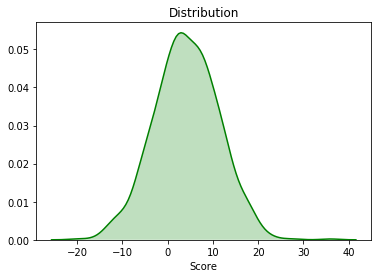

In [177]:
score = indicator1['Score'].dropna()
sns.distplot(score, hist=False, color="g", kde_kws={"shade": True}).set_title('Distribution')

/home/liangchen/anaconda2/envs/py37/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/liangchen/anaconda2/envs/py37/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 1.0, '1d return')

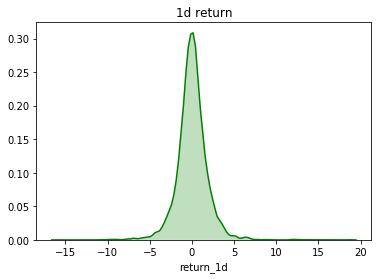

In [178]:
sns.distplot(price['return_1d'], hist=False, color="g", kde_kws={"shade": True}).set_title('1d return')

## Classify our score data and return

In [179]:
target = price_indicator_forward['Score']
mean = target.mean()
std = target.std()
tier = 5
tier_lst = [0.159,0.309,0.691,0.841]
price_indicator_forward['Discrete_score'] = target.apply(lambda x: discrete(x,tier,tier_lst,mean,std))-2

Number of 0 in discrete_1d : 0.334177
Number of 1 in discrete_1d : 0.334177
Number of -1 in discrete_1d : 0.331646
Accuracy for following the same sign of Indicator 1 discrete_1d : 0.349367
Accuracy for following the reverse sign of Indicator 1 discrete_1d : 0.334177
[-1.19295728 -0.43143052  0.46355324  1.19295728]


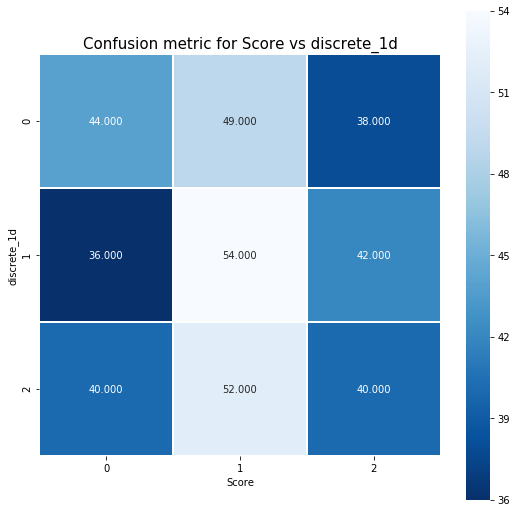

In [223]:
target = price_indicator_forward['return_1d']
output_name = 'discrete_1d'
mean = 0
std = target.std()
tier = 5
tier_lst = [0.159,0.359,0.651,0.841]
price_indicator_forward[output_name] = target.apply(lambda x: discrete(x,tier,tier_lst,mean,std))-2
prediction(output_name,price_indicator_forward,'Discrete_score')
result = draw_confusion(price_indicator_forward,output_name,'Discrete_score')
print(norm.ppf(tier_lst, loc=mean, scale=std))

Number of 1 in discrete_3d : 0.336709
Number of 0 in discrete_3d : 0.334177
Number of -1 in discrete_3d : 0.329114
Accuracy for following the same sign of Indicator 1 discrete_3d : 0.326582
Accuracy for following the reverse sign of Indicator 1 discrete_3d : 0.318987
[-2.06427663 -0.6914913   0.74654136  2.06427663]


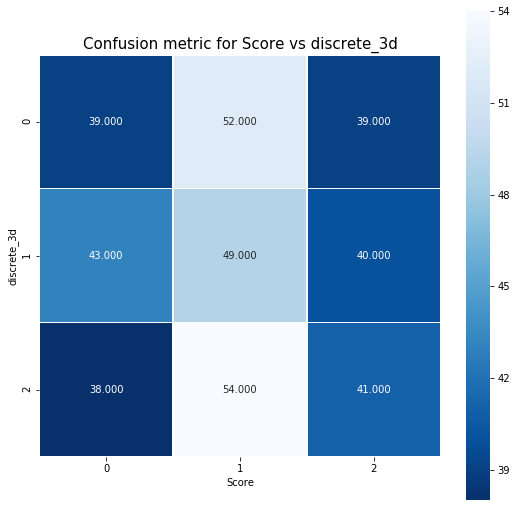

In [227]:
target = price_indicator_forward['return_3d']
output_name = 'discrete_3d'
mean = 0
std = target.std()
tier = 5
tier_lst = [0.159,0.369,0.641,0.841]
price_indicator_forward[output_name] = target.apply(lambda x: discrete(x,tier,tier_lst,mean,std))-2
prediction(output_name,price_indicator_forward,'Discrete_score')
result = draw_confusion(price_indicator_forward,output_name,'Discrete_score')
print(norm.ppf(tier_lst, loc=mean, scale=std))

Number of 0 in discrete_5d : 0.339241
Number of -1 in discrete_5d : 0.331646
Number of 1 in discrete_5d : 0.329114
Accuracy for following the same sign of Indicator 1 discrete_5d : 0.318987
Accuracy for following the reverse sign of Indicator 1 discrete_5d : 0.321519
[-2.80528385 -1.02957233  1.01452507  2.80528385]


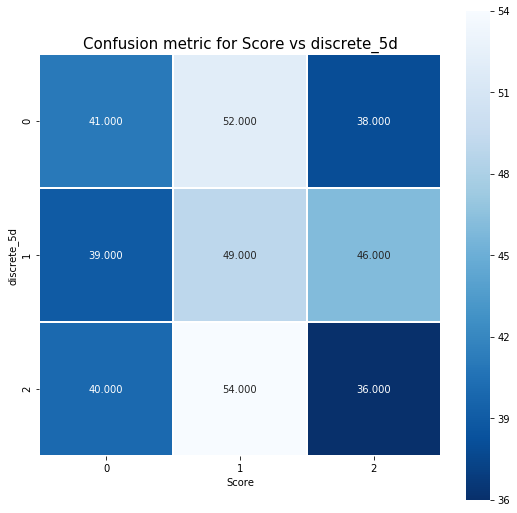

In [232]:
target = price_indicator_forward['return_5d']
output_name = 'discrete_5d'
mean = 0
std = target.std()
tier = 5
tier_lst = [0.159,0.357,0.641,0.841]
price_indicator_forward[output_name] = target.apply(lambda x: discrete(x,tier,tier_lst,mean,std))-2
prediction(output_name,price_indicator_forward,'Discrete_score')
result = draw_confusion(price_indicator_forward,output_name,'Discrete_score')
print(norm.ppf(tier_lst, loc=mean, scale=std))

Number of 0 in discrete_7d : 0.339241
Number of -1 in discrete_7d : 0.331646
Number of 1 in discrete_7d : 0.329114
Accuracy for following the same sign of Indicator 1 discrete_7d : 0.324051
Accuracy for following the reverse sign of Indicator 1 discrete_7d : 0.35443
[-3.29763492 -1.28137813  1.28137813  3.29763492]


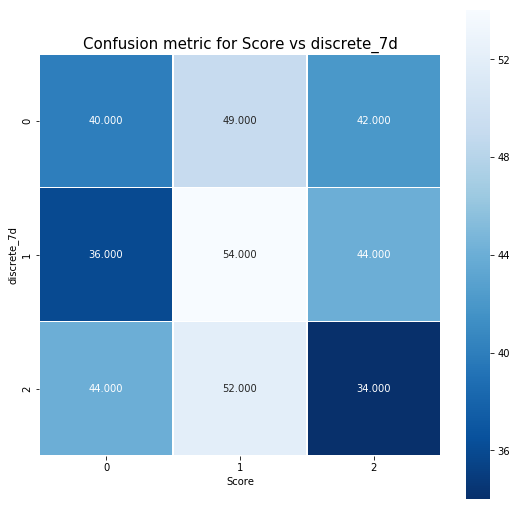

In [215]:
target = price_indicator_forward['return_7d']
output_name = 'discrete_7d'
mean = 0
std = target.std()
tier = 5
tier_lst = [0.159,0.349,0.651,0.841]
price_indicator_forward[output_name] = target.apply(lambda x: discrete(x,tier,tier_lst,mean,std))-2
prediction(output_name,price_indicator_forward,'Discrete_score')
result = draw_confusion(price_indicator_forward,output_name,'Discrete_score')
print(norm.ppf(tier_lst, loc=mean, scale=std))

Number of 0 in discrete_10d : 0.339241
Number of 1 in discrete_10d : 0.331646
Number of -1 in discrete_10d : 0.329114
Accuracy for following the same sign of Indicator 1 discrete_10d : 0.318987
Accuracy for following the reverse sign of Indicator 1 discrete_10d : 0.367089
[-4.08221646 -1.4763251   1.4763251   4.08221646]


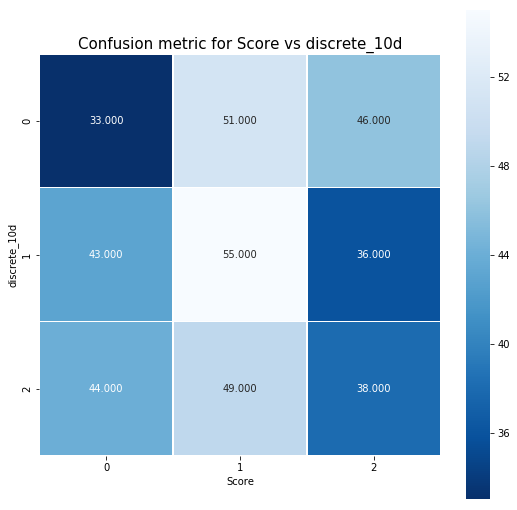

In [220]:
target = price_indicator_forward['return_10d']
output_name = 'discrete_10d'
mean = 0
std = target.std()
tier = 5
tier_lst = [0.159,0.359,0.641,0.841]
price_indicator_forward[output_name] = target.apply(lambda x: discrete(x,tier,tier_lst,mean,std))-2
prediction(output_name,price_indicator_forward,'Discrete_score')
result = draw_confusion(price_indicator_forward,output_name,'Discrete_score')
print(norm.ppf(tier_lst, loc=mean, scale=std))

Number of -1 in discrete_15d : 0.339241
Number of 1 in discrete_15d : 0.339241
Number of 0 in discrete_15d : 0.321519
Accuracy for following the same sign of Indicator 1 discrete_15d : 0.306329
Accuracy for following the reverse sign of Indicator 1 discrete_15d : 0.336709
[-5.20281221 -2.3064446   2.02168219  5.20281221]


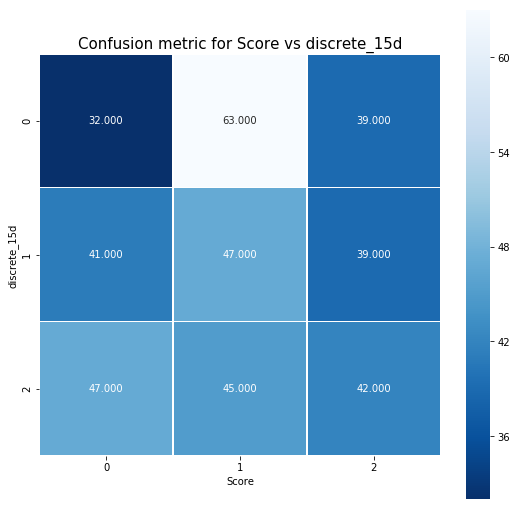

In [240]:
target = price_indicator_forward['return_15d']
output_name = 'discrete_15d'
mean = 0
std = target.std()
tier = 5
tier_lst = [0.159,0.329,0.651,0.841]
price_indicator_forward[output_name] = target.apply(lambda x: discrete(x,tier,tier_lst,mean,std))-2
prediction(output_name,price_indicator_forward,'Discrete_score')
result = draw_confusion(price_indicator_forward,output_name,'Discrete_score')
print(norm.ppf(tier_lst, loc=mean, scale=std))

Number of 0 in discrete_20d : 0.339241
Number of -1 in discrete_20d : 0.331646
Number of 1 in discrete_20d : 0.329114
Accuracy for following the same sign of Indicator 1 discrete_20d : 0.326582
Accuracy for following the reverse sign of Indicator 1 discrete_20d : 0.367089
[-6.10714866 -2.5392658   1.80412852  6.10714866]


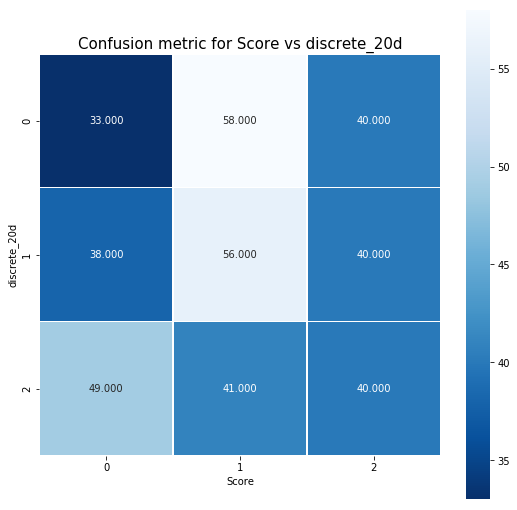

In [241]:
target = price_indicator_forward['return_20d']
output_name = 'discrete_20d'
mean = 0
std = target.std()
tier = 5
tier_lst = [0.159,0.339,0.616,0.841]
price_indicator_forward[output_name] = target.apply(lambda x: discrete(x,tier,tier_lst,mean,std))-2
prediction(output_name,price_indicator_forward,'Discrete_score')
result = draw_confusion(price_indicator_forward,output_name,'Discrete_score')
print(norm.ppf(tier_lst, loc=mean, scale=std))

Number of -1 in discrete_20d : 0.349367
Number of 0 in discrete_20d : 0.344304
Number of 1 in discrete_20d : 0.306329
Accuracy for following the same sign of Indicator 1 discrete_20d : 0.329114
Accuracy for following the reverse sign of Indicator 1 discrete_20d : 0.359494
[-6.10714866 -2.37308463  2.37308463  6.10714866]


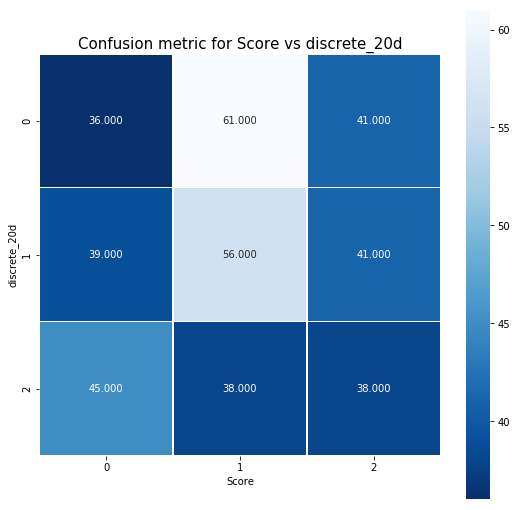

In [242]:
target = price_indicator_forward['return_20d']
output_name = 'discrete_20d'
mean = 0
std = target.std()
tier = 5
tier_lst = [0.159,0.349,0.651,0.841]
price_indicator_forward[output_name] = target.apply(lambda x: discrete(x,tier,tier_lst,mean,std))-2
prediction(output_name,price_indicator_forward,'Discrete_score')
result = draw_confusion(price_indicator_forward,output_name,'Discrete_score')
print(norm.ppf(tier_lst, loc=mean, scale=std))

### Conclusion
1. In short term, we follow the same direction as the indicator. Howeverm, in long term, we go against it
2. After modifying the range, we can see our indicator can beat the majority class in most of the cases  